In [1]:
"""
NDVI (Normalized Difference Vegetation Index)
This most known and used vegetation index is a simple,
but effective VI for quantifying green vegetation.
It normalizes green leaf scattering in the Near Infra-red wavelength and chlorophyll absorption in the red wavelength.
Values description: The value range of an NDVI is -1 to 1. 
Negative values of NDVI (values approaching -1) correspond to water. 
Values close to zero (-0.1 to 0.1) generally correspond to barren areas of rock, sand, or snow. 
Low, positive values represent shrub and grassland (approximately 0.2 to 0.4), 
while high values indicate temperate and tropical rainforests (values approaching 1).
"""


"""
NDWI (Normalized Difference Water Index)
The NDWI index is most appropriate for water body mapping. 
The water body has strong absorbability and low radiation in the range from visible to infrared wavelengths. 
The index uses the green and Near Infra-red bands of remote sensing images based on this phenomenon. 
The NDWI can enhance the water information effectively in most cases. 
It is sensitive to built-up land and often results in over-estimated water bodies. 

Values description: Values of water bodies are larger than 0.5. 
Vegetation has much smaller values, which results in distinguishing vegetation from water bodies easier. 
Built-up features have positive values between zero and 0.2.
"""

# Look at other indices also, at https://www.sentinel-hub.com/develop/documentation/eo_products/Sentinel2EOproducts

#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask
import fiona
import pandas as pd
from helpers import return_indices
%matplotlib inline


In [2]:
# For testing also we need all of this
blue = rasterio.open('./All_Indices/S2_Mandya_B2.tif')
green = rasterio.open('./All_Indices/S2_Mandya_B3.tif')
red = rasterio.open('./All_Indices/S2_Mandya_B4.tif')
vre5 = rasterio.open('./All_Indices/S2_Mandya_B05.tif')
vre6 = rasterio.open('./All_Indices/S2_Mandya_B06.tif')
vre7 = rasterio.open('./All_Indices/S2_Mandya_B07.tif')
nir = rasterio.open('./All_Indices/S2_Mandya_B8.tif')
vre8a = rasterio.open('./All_Indices/S2_Mandya_B08A.tif')
swir11 = rasterio.open('./All_Indices/S2_Mandya_B11.tif')
swir12 = rasterio.open('./All_Indices/S2_Mandya_B12.tif')

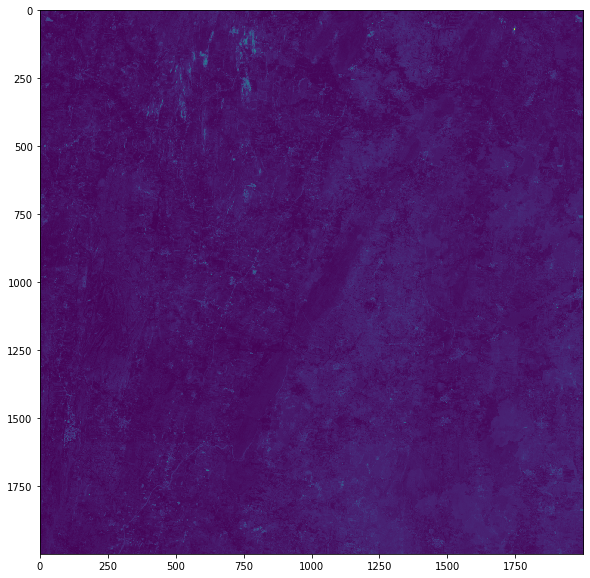

In [25]:
fig = plt.figure(figsize=(10,10))
img1 = blue.read(1)
plot.show(img1[3000:5000, 4000:6000])

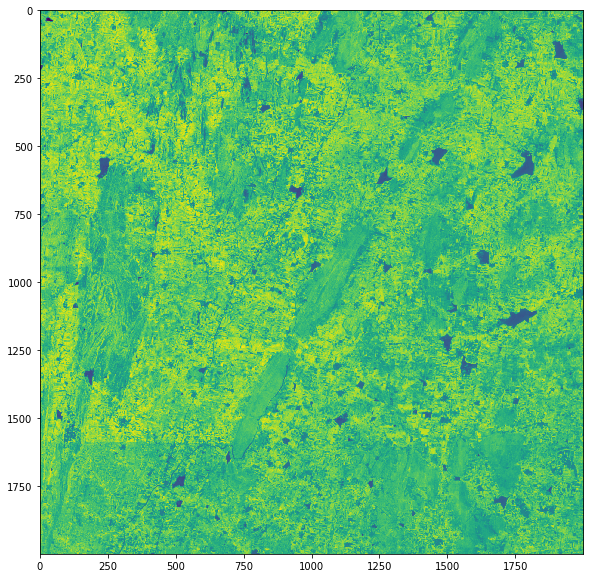

In [26]:
# ndvi from qgis
ndvi_8_4 = rasterio.open('./All_Indices/ndvi_8_4.tif')
fig = plt.figure(figsize=(10,10))
img = ndvi_8_4.read(1)
plot.show(img[3000:5000, 4000:6000])

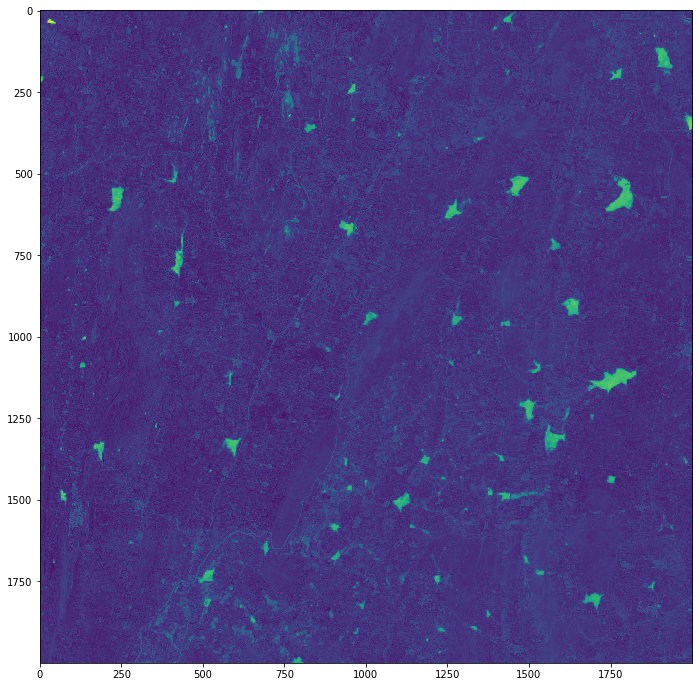

In [28]:
mndwi_4_11 = rasterio.open('./All_Indices/mndwi_4_11.tif')
fig = plt.figure(figsize=(18,12))
img = mndwi_4_11.read(1)
plot.show(img[3000:5000, 4000:6000])

In [35]:
# Final numpy array must be structured as follows
# Shape of array - [14, 10131, 12032]
# n - number of features / indices considered

# Features : [B02, B03, B04, B05, B06, B07, B8, B08A, B11, B12, ndvi, mndwi, ndbi]

In [36]:
feature_list = ["S2_Mandya_B2", "S2_Mandya_B3", "S2_Mandya_B4", "S2_Mandya_B05", "S2_Mandya_B06", 
                "S2_Mandya_B07", "S2_Mandya_B8", "S2_Mandya_B08A", "S2_Mandya_B11", "S2_Mandya_B12", 
                "ndvi_8_4", "mndwi_4_11", "ndbi_11_8"]
# "ndvi_8_4", "mndwi_4_11", "ndbi_11_8" will be added later in code
FOLDER = "./All_Indices/"

In [37]:
final_feature_array = []

In [38]:
# Indices are computed in helpers
for feature in feature_list[0:-3]:
    file = FOLDER + feature + ".tif"
    with rasterio.open(file) as src:
        image = src.read(1)
        final_feature_array.append(image[3000:5000, 4000:6000])

In [39]:
ndvi, mndwi, ndbi = return_indices(final_feature_array)

In [40]:
final_feature_array.append(ndvi)
final_feature_array.append(mndwi)
final_feature_array.append(ndbi)

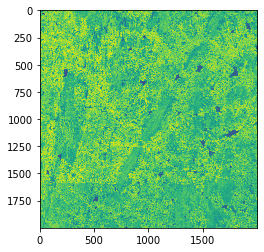

In [41]:
# ndvi from rasterio
plot.show(final_feature_array[-3])

In [42]:
final_features = np.array(final_feature_array)

In [43]:
# Normalize features to same scale before training

In [44]:
final_features.shape

(13, 2000, 2000)

In [45]:
with fiona.open("C:\\Users\\anude\\Desktop\\MandyaV1\\Plantations\\Plantations.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [46]:
with rasterio.open("./All_Indices/ndvi_8_4.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff",
     "height": out_image.shape[1],
     "width": out_image.shape[2],
     "transform": out_transform})

In [47]:
with rasterio.open("./target_tifs/masked_plantations_ndvi.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [48]:
out_image.shape

(4, 10131, 12032)

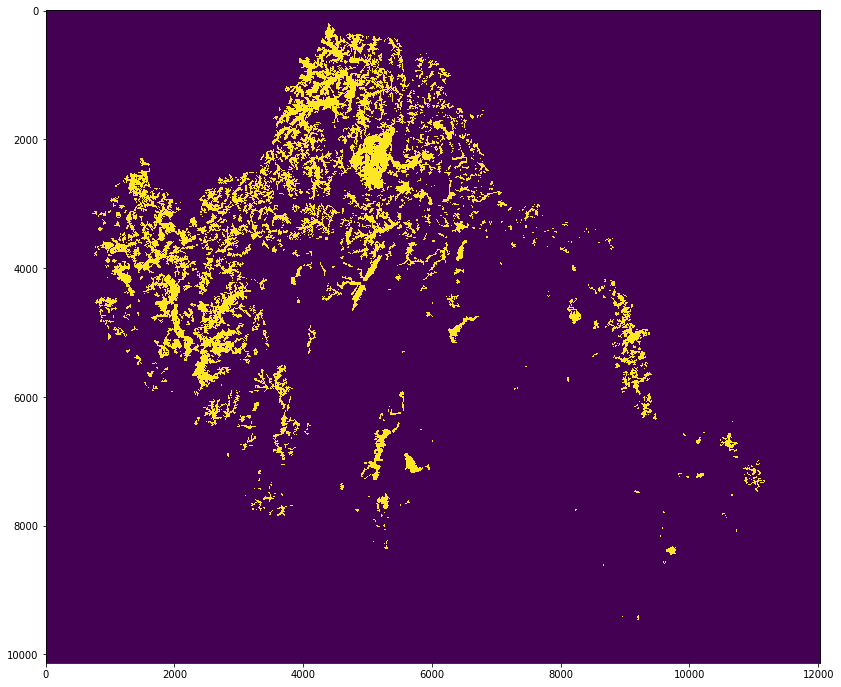

In [97]:
with rasterio.open('./target_tifs/masked_plantations_ndvi.tif') as water_mask:
    mandya_water_mask = water_mask.read(4)
fig = plt.figure(figsize=(18, 12))
plot.show(mandya_water_mask)

In [51]:
with fiona.open("./shpfiles/correct_distshapefile.shp", "r") as shapefile:
    shapes_dist = [feature["geometry"] for feature in shapefile]

In [54]:
with rasterio.open("./All_Indices/ndvi_8_4.tif") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes_dist, crop=False)
    out_meta = src.meta
    
out_meta.update(
    {"driver": "GTiff", 
     "height": out_image.shape[1], 
     "width": out_image.shape[2],
     "transform": out_transform})

In [55]:
out_image[0].shape

(10131, 12032)

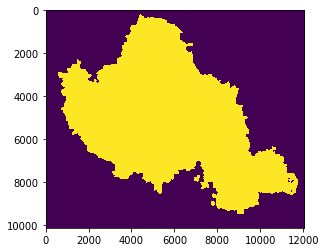

In [56]:
plot.show(out_image[3])

In [57]:
with rasterio.open("./target_tifs/masked_dist.tif", "w", **out_meta) as dest:
    dest.write(out_image)

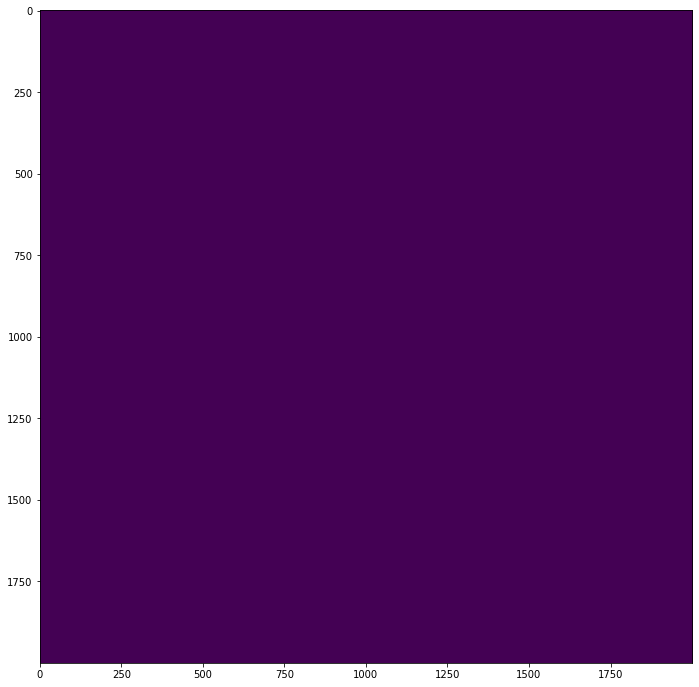

In [58]:
with rasterio.open('./target_tifs/masked_dist.tif') as dist_mask:
    mandya_dist_mask = dist_mask.read(4)

fig = plt.figure(figsize=(18, 12))
plot.show(mandya_dist_mask[3000:5000, 4000:6000])

### Data Pre-processing

In [59]:
final_features = np.array(final_feature_array) # Each training example (so reshape into (12032*10131, 14))
final_features[:,0,0]

array([ 0.1059    ,  0.1129    ,  0.1186    ,  0.1554    ,  0.2217    ,
        0.2575    ,  0.2522    ,  0.2849    ,  0.2862    ,  0.1816    ,
        0.36030205, -0.41403162,  0.06315007])

In [60]:
final_features.shape

(13, 2000, 2000)

In [61]:
for i in range(len(final_features)):
    print(feature_list[i], "=", final_features[i].min(), final_features[i].max())

S2_Mandya_B2 = 0.0741 0.5064
S2_Mandya_B3 = 0.0576 0.5165
S2_Mandya_B4 = 0.0382 0.5823
S2_Mandya_B05 = 0.0359 0.5172
S2_Mandya_B06 = 0.0405 0.5741
S2_Mandya_B07 = 0.0463 0.5776
S2_Mandya_B8 = 0.0392 0.6073
S2_Mandya_B08A = 0.0354 0.5756
S2_Mandya_B11 = 0.0172 0.7626
S2_Mandya_B12 = 0.0107 0.7477
ndvi_8_4 = -0.3510980966325037 0.8052180840470026
mndwi_4_11 = -0.6634382566585957 0.7794117647058824
ndbi_11_8 = -0.739588319770225 0.47893481717011127


In [62]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

In [63]:
normalized_features = []

In [64]:
for i in range(len(final_feature_array)):
    print(i)
    normalized_features.append(normalize(final_feature_array[i]))

0
1
2
3
4
5
6
7
8
9
10
11
12


In [65]:
normalized_features = np.array(normalized_features)
normalized_features.shape

(13, 2000, 2000)

In [66]:
shp = normalized_features.shape
pd.DataFrame(normalized_features.reshape((shp[0], shp[1]*shp[2])))

,0,1,2,3,4,5,6,7,8,9,...,3999990,3999991,3999992,3999993,3999994,3999995,3999996,3999997,3999998,3999999
0,0.073560,0.068240,0.060606,0.057830,0.061531,0.062919,0.059681,0.054823,0.053666,0.061994,...,0.048115,0.058062,0.060375,0.098311,0.168170,0.137636,0.095073,0.082813,0.081656,0.066620
1,0.120506,0.107867,0.098061,0.091523,0.088908,0.095446,0.096753,0.098932,0.086729,0.100022,...,0.072347,0.083025,0.090434,0.096099,0.178034,0.176945,0.117237,0.125082,0.121159,0.108302
2,0.147767,0.135269,0.125712,0.119096,0.122036,0.124793,0.133983,0.133431,0.120934,0.146113,...,0.071678,0.075538,0.097225,0.123690,0.160081,0.158794,0.144275,0.147583,0.109355,0.090241
3,0.248286,0.236651,0.236651,0.218990,0.218990,0.221068,0.221068,0.226678,0.226678,0.234781,...,0.130895,0.130895,0.179514,0.179514,0.232495,0.232495,0.203407,0.203407,0.178059,0.178059
4,0.339580,0.324588,0.324588,0.302849,0.302849,0.311657,0.311657,0.321214,0.321214,0.327961,...,0.294790,0.294790,0.296102,0.296102,0.332271,0.332271,0.312969,0.312969,0.307346,0.307346
5,0.397516,0.389422,0.389422,0.361190,0.361190,0.352720,0.352720,0.372859,0.372859,0.382458,...,0.374553,0.374553,0.348203,0.348203,0.406174,0.406174,0.374741,0.374741,0.361001,0.361001
6,0.374934,0.375990,0.375286,0.338145,0.329519,0.342545,0.340609,0.345186,0.351171,0.358388,...,0.269319,0.282873,0.274776,0.297483,0.343778,0.344834,0.298539,0.327759,0.350819,0.354867
7,0.461866,0.452610,0.452610,0.422991,0.422991,0.420030,0.420030,0.436135,0.436135,0.449648,...,0.397260,0.397260,0.392632,0.392632,0.481488,0.481488,0.426324,0.426324,0.408552,0.408552
8,0.360880,0.359941,0.359941,0.346391,0.346391,0.353904,0.353904,0.366380,0.366380,0.370673,...,0.239066,0.239066,0.269922,0.269922,0.310706,0.310706,0.309364,0.309364,0.285484,0.285484
9,0.231886,0.223745,0.223745,0.213704,0.213704,0.226323,0.226323,0.225237,0.225237,0.233243,...,0.142334,0.142334,0.180054,0.180054,0.220081,0.220081,0.214518,0.214518,0.182090,0.182090


In [67]:
normalized_features = normalized_features.reshape((shp[0], shp[1]*shp[2]))

In [68]:
normalized_features.shape

(13, 4000000)

In [69]:
# pd.DataFrame(normalized_features.T).to_csv("./Understanding the Data/reshaped_norm_features.csv")

In [70]:
normalized_features = normalized_features.T

In [71]:
# Train data is done
# Target must be obtained (0/1)
mandya_dist_mask = mandya_dist_mask[3000:5000, 4000:6000]
mandya_water_mask = mandya_water_mask[3000:5000, 4000:6000]

In [72]:
mandya_dist_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [73]:
normalized_features.shape

(4000000, 13)

In [74]:
# 1. Map pixel numbers to x,y coordinates of image
# 2. Choose only those pixels that are inside the mandya region
# 3. Choose target as 1 if pixel number in both masks is non-zero
# mandya_dist_mask, mandya_water_mask
pixel_positions = []
in_mandya_features = []
target_values = []
dim = mandya_dist_mask.shape
for i in range(dim[0]):
    for j in range(dim[1]):
        if(mandya_dist_mask[i,j]!=0):
            in_mandya_features.append(normalized_features[i*dim[0]+j])
            pixel_positions.append((i,j))
            if(mandya_water_mask[i,j]!=0):
                target_values.append(1)
            else:
                target_values.append(0)
            if(i%1000==0 or j%1000==0):
                print((i*dim[0]+j, i, j))

(0, 0, 0)
(1, 0, 1)
(2, 0, 2)
(3, 0, 3)
(4, 0, 4)
(5, 0, 5)
(6, 0, 6)
(7, 0, 7)
(8, 0, 8)
(9, 0, 9)
(10, 0, 10)
(11, 0, 11)
(12, 0, 12)
(13, 0, 13)
(14, 0, 14)
(15, 0, 15)
(16, 0, 16)
(17, 0, 17)
(18, 0, 18)
(19, 0, 19)
(20, 0, 20)
(21, 0, 21)
(22, 0, 22)
(23, 0, 23)
(24, 0, 24)
(25, 0, 25)
(26, 0, 26)
(27, 0, 27)
(28, 0, 28)
(29, 0, 29)
(30, 0, 30)
(31, 0, 31)
(32, 0, 32)
(33, 0, 33)
(34, 0, 34)
(35, 0, 35)
(36, 0, 36)
(37, 0, 37)
(38, 0, 38)
(39, 0, 39)
(40, 0, 40)
(41, 0, 41)
(42, 0, 42)
(43, 0, 43)
(44, 0, 44)
(45, 0, 45)
(46, 0, 46)
(47, 0, 47)
(48, 0, 48)
(49, 0, 49)
(50, 0, 50)
(51, 0, 51)
(52, 0, 52)
(53, 0, 53)
(54, 0, 54)
(55, 0, 55)
(56, 0, 56)
(57, 0, 57)
(58, 0, 58)
(59, 0, 59)
(60, 0, 60)
(61, 0, 61)
(62, 0, 62)
(63, 0, 63)
(64, 0, 64)
(65, 0, 65)
(66, 0, 66)
(67, 0, 67)
(68, 0, 68)
(69, 0, 69)
(70, 0, 70)
(71, 0, 71)
(72, 0, 72)
(73, 0, 73)
(74, 0, 74)
(75, 0, 75)
(76, 0, 76)
(77, 0, 77)
(78, 0, 78)
(79, 0, 79)
(80, 0, 80)
(81, 0, 81)
(82, 0, 82)
(83, 0, 83)
(84, 0, 84)


(1382, 0, 1382)
(1383, 0, 1383)
(1384, 0, 1384)
(1385, 0, 1385)
(1386, 0, 1386)
(1387, 0, 1387)
(1388, 0, 1388)
(1389, 0, 1389)
(1390, 0, 1390)
(1391, 0, 1391)
(1392, 0, 1392)
(1393, 0, 1393)
(1394, 0, 1394)
(1395, 0, 1395)
(1396, 0, 1396)
(1397, 0, 1397)
(1398, 0, 1398)
(1399, 0, 1399)
(1400, 0, 1400)
(1401, 0, 1401)
(1402, 0, 1402)
(1403, 0, 1403)
(1404, 0, 1404)
(1405, 0, 1405)
(1406, 0, 1406)
(1407, 0, 1407)
(1408, 0, 1408)
(1409, 0, 1409)
(1410, 0, 1410)
(1411, 0, 1411)
(1412, 0, 1412)
(1413, 0, 1413)
(1414, 0, 1414)
(1415, 0, 1415)
(1416, 0, 1416)
(1417, 0, 1417)
(1418, 0, 1418)
(1419, 0, 1419)
(1420, 0, 1420)
(1421, 0, 1421)
(1422, 0, 1422)
(1423, 0, 1423)
(1424, 0, 1424)
(1425, 0, 1425)
(1426, 0, 1426)
(1427, 0, 1427)
(1428, 0, 1428)
(1429, 0, 1429)
(1430, 0, 1430)
(1431, 0, 1431)
(1432, 0, 1432)
(1433, 0, 1433)
(1434, 0, 1434)
(1435, 0, 1435)
(1436, 0, 1436)
(1437, 0, 1437)
(1438, 0, 1438)
(1439, 0, 1439)
(1440, 0, 1440)
(1441, 0, 1441)
(1442, 0, 1442)
(1443, 0, 1443)
(1444, 0

(105000, 52, 1000)
(106000, 53, 0)
(107000, 53, 1000)
(108000, 54, 0)
(109000, 54, 1000)
(110000, 55, 0)
(111000, 55, 1000)
(112000, 56, 0)
(113000, 56, 1000)
(114000, 57, 0)
(115000, 57, 1000)
(116000, 58, 0)
(117000, 58, 1000)
(118000, 59, 0)
(119000, 59, 1000)
(120000, 60, 0)
(121000, 60, 1000)
(122000, 61, 0)
(123000, 61, 1000)
(124000, 62, 0)
(125000, 62, 1000)
(126000, 63, 0)
(127000, 63, 1000)
(128000, 64, 0)
(129000, 64, 1000)
(130000, 65, 0)
(131000, 65, 1000)
(132000, 66, 0)
(133000, 66, 1000)
(134000, 67, 0)
(135000, 67, 1000)
(136000, 68, 0)
(137000, 68, 1000)
(138000, 69, 0)
(139000, 69, 1000)
(140000, 70, 0)
(141000, 70, 1000)
(142000, 71, 0)
(143000, 71, 1000)
(144000, 72, 0)
(145000, 72, 1000)
(146000, 73, 0)
(147000, 73, 1000)
(148000, 74, 0)
(149000, 74, 1000)
(150000, 75, 0)
(151000, 75, 1000)
(152000, 76, 0)
(153000, 76, 1000)
(154000, 77, 0)
(155000, 77, 1000)
(156000, 78, 0)
(157000, 78, 1000)
(158000, 79, 0)
(159000, 79, 1000)
(160000, 80, 0)
(161000, 80, 1000)
(

(652000, 326, 0)
(653000, 326, 1000)
(654000, 327, 0)
(655000, 327, 1000)
(656000, 328, 0)
(657000, 328, 1000)
(658000, 329, 0)
(659000, 329, 1000)
(660000, 330, 0)
(661000, 330, 1000)
(662000, 331, 0)
(663000, 331, 1000)
(664000, 332, 0)
(665000, 332, 1000)
(666000, 333, 0)
(667000, 333, 1000)
(668000, 334, 0)
(669000, 334, 1000)
(670000, 335, 0)
(671000, 335, 1000)
(672000, 336, 0)
(673000, 336, 1000)
(674000, 337, 0)
(675000, 337, 1000)
(676000, 338, 0)
(677000, 338, 1000)
(678000, 339, 0)
(679000, 339, 1000)
(680000, 340, 0)
(681000, 340, 1000)
(682000, 341, 0)
(683000, 341, 1000)
(684000, 342, 0)
(685000, 342, 1000)
(686000, 343, 0)
(687000, 343, 1000)
(688000, 344, 0)
(689000, 344, 1000)
(690000, 345, 0)
(691000, 345, 1000)
(692000, 346, 0)
(693000, 346, 1000)
(694000, 347, 0)
(695000, 347, 1000)
(696000, 348, 0)
(697000, 348, 1000)
(698000, 349, 0)
(699000, 349, 1000)
(700000, 350, 0)
(701000, 350, 1000)
(702000, 351, 0)
(703000, 351, 1000)
(704000, 352, 0)
(705000, 352, 1000)
(

(1329000, 664, 1000)
(1330000, 665, 0)
(1331000, 665, 1000)
(1332000, 666, 0)
(1333000, 666, 1000)
(1334000, 667, 0)
(1335000, 667, 1000)
(1336000, 668, 0)
(1337000, 668, 1000)
(1338000, 669, 0)
(1339000, 669, 1000)
(1340000, 670, 0)
(1341000, 670, 1000)
(1342000, 671, 0)
(1343000, 671, 1000)
(1344000, 672, 0)
(1345000, 672, 1000)
(1346000, 673, 0)
(1347000, 673, 1000)
(1348000, 674, 0)
(1349000, 674, 1000)
(1350000, 675, 0)
(1351000, 675, 1000)
(1352000, 676, 0)
(1353000, 676, 1000)
(1354000, 677, 0)
(1355000, 677, 1000)
(1356000, 678, 0)
(1357000, 678, 1000)
(1358000, 679, 0)
(1359000, 679, 1000)
(1360000, 680, 0)
(1361000, 680, 1000)
(1362000, 681, 0)
(1363000, 681, 1000)
(1364000, 682, 0)
(1365000, 682, 1000)
(1366000, 683, 0)
(1367000, 683, 1000)
(1368000, 684, 0)
(1369000, 684, 1000)
(1370000, 685, 0)
(1371000, 685, 1000)
(1372000, 686, 0)
(1373000, 686, 1000)
(1374000, 687, 0)
(1375000, 687, 1000)
(1376000, 688, 0)
(1377000, 688, 1000)
(1378000, 689, 0)
(1379000, 689, 1000)
(138

(1960000, 980, 0)
(1961000, 980, 1000)
(1962000, 981, 0)
(1963000, 981, 1000)
(1964000, 982, 0)
(1965000, 982, 1000)
(1966000, 983, 0)
(1967000, 983, 1000)
(1968000, 984, 0)
(1969000, 984, 1000)
(1970000, 985, 0)
(1971000, 985, 1000)
(1972000, 986, 0)
(1973000, 986, 1000)
(1974000, 987, 0)
(1975000, 987, 1000)
(1976000, 988, 0)
(1977000, 988, 1000)
(1978000, 989, 0)
(1979000, 989, 1000)
(1980000, 990, 0)
(1981000, 990, 1000)
(1982000, 991, 0)
(1983000, 991, 1000)
(1984000, 992, 0)
(1985000, 992, 1000)
(1986000, 993, 0)
(1987000, 993, 1000)
(1988000, 994, 0)
(1989000, 994, 1000)
(1990000, 995, 0)
(1991000, 995, 1000)
(1992000, 996, 0)
(1993000, 996, 1000)
(1994000, 997, 0)
(1995000, 997, 1000)
(1996000, 998, 0)
(1997000, 998, 1000)
(1998000, 999, 0)
(1999000, 999, 1000)
(2000000, 1000, 0)
(2000001, 1000, 1)
(2000002, 1000, 2)
(2000003, 1000, 3)
(2000004, 1000, 4)
(2000005, 1000, 5)
(2000006, 1000, 6)
(2000007, 1000, 7)
(2000008, 1000, 8)
(2000009, 1000, 9)
(2000010, 1000, 10)
(2000011, 

(2001298, 1000, 1298)
(2001299, 1000, 1299)
(2001300, 1000, 1300)
(2001301, 1000, 1301)
(2001302, 1000, 1302)
(2001303, 1000, 1303)
(2001304, 1000, 1304)
(2001305, 1000, 1305)
(2001306, 1000, 1306)
(2001307, 1000, 1307)
(2001308, 1000, 1308)
(2001309, 1000, 1309)
(2001310, 1000, 1310)
(2001311, 1000, 1311)
(2001312, 1000, 1312)
(2001313, 1000, 1313)
(2001314, 1000, 1314)
(2001315, 1000, 1315)
(2001316, 1000, 1316)
(2001317, 1000, 1317)
(2001318, 1000, 1318)
(2001319, 1000, 1319)
(2001320, 1000, 1320)
(2001321, 1000, 1321)
(2001322, 1000, 1322)
(2001323, 1000, 1323)
(2001324, 1000, 1324)
(2001325, 1000, 1325)
(2001326, 1000, 1326)
(2001327, 1000, 1327)
(2001328, 1000, 1328)
(2001329, 1000, 1329)
(2001330, 1000, 1330)
(2001331, 1000, 1331)
(2001332, 1000, 1332)
(2001333, 1000, 1333)
(2001334, 1000, 1334)
(2001335, 1000, 1335)
(2001336, 1000, 1336)
(2001337, 1000, 1337)
(2001338, 1000, 1338)
(2001339, 1000, 1339)
(2001340, 1000, 1340)
(2001341, 1000, 1341)
(2001342, 1000, 1342)
(2001343, 

(2041000, 1020, 1000)
(2042000, 1021, 0)
(2043000, 1021, 1000)
(2044000, 1022, 0)
(2045000, 1022, 1000)
(2046000, 1023, 0)
(2047000, 1023, 1000)
(2048000, 1024, 0)
(2049000, 1024, 1000)
(2050000, 1025, 0)
(2051000, 1025, 1000)
(2052000, 1026, 0)
(2053000, 1026, 1000)
(2054000, 1027, 0)
(2055000, 1027, 1000)
(2056000, 1028, 0)
(2057000, 1028, 1000)
(2058000, 1029, 0)
(2059000, 1029, 1000)
(2060000, 1030, 0)
(2061000, 1030, 1000)
(2062000, 1031, 0)
(2063000, 1031, 1000)
(2064000, 1032, 0)
(2065000, 1032, 1000)
(2066000, 1033, 0)
(2067000, 1033, 1000)
(2068000, 1034, 0)
(2069000, 1034, 1000)
(2070000, 1035, 0)
(2071000, 1035, 1000)
(2072000, 1036, 0)
(2073000, 1036, 1000)
(2074000, 1037, 0)
(2075000, 1037, 1000)
(2076000, 1038, 0)
(2077000, 1038, 1000)
(2078000, 1039, 0)
(2079000, 1039, 1000)
(2080000, 1040, 0)
(2081000, 1040, 1000)
(2082000, 1041, 0)
(2083000, 1041, 1000)
(2084000, 1042, 0)
(2085000, 1042, 1000)
(2086000, 1043, 0)
(2087000, 1043, 1000)
(2088000, 1044, 0)
(2089000, 1044, 

(2480000, 1240, 0)
(2481000, 1240, 1000)
(2482000, 1241, 0)
(2483000, 1241, 1000)
(2484000, 1242, 0)
(2485000, 1242, 1000)
(2486000, 1243, 0)
(2487000, 1243, 1000)
(2488000, 1244, 0)
(2489000, 1244, 1000)
(2490000, 1245, 0)
(2491000, 1245, 1000)
(2492000, 1246, 0)
(2493000, 1246, 1000)
(2494000, 1247, 0)
(2495000, 1247, 1000)
(2496000, 1248, 0)
(2497000, 1248, 1000)
(2498000, 1249, 0)
(2499000, 1249, 1000)
(2500000, 1250, 0)
(2501000, 1250, 1000)
(2502000, 1251, 0)
(2503000, 1251, 1000)
(2504000, 1252, 0)
(2505000, 1252, 1000)
(2506000, 1253, 0)
(2507000, 1253, 1000)
(2508000, 1254, 0)
(2509000, 1254, 1000)
(2510000, 1255, 0)
(2511000, 1255, 1000)
(2512000, 1256, 0)
(2513000, 1256, 1000)
(2514000, 1257, 0)
(2515000, 1257, 1000)
(2516000, 1258, 0)
(2517000, 1258, 1000)
(2518000, 1259, 0)
(2519000, 1259, 1000)
(2520000, 1260, 0)
(2521000, 1260, 1000)
(2522000, 1261, 0)
(2523000, 1261, 1000)
(2524000, 1262, 0)
(2525000, 1262, 1000)
(2526000, 1263, 0)
(2527000, 1263, 1000)
(2528000, 1264, 

(2935000, 1467, 1000)
(2936000, 1468, 0)
(2937000, 1468, 1000)
(2938000, 1469, 0)
(2939000, 1469, 1000)
(2940000, 1470, 0)
(2941000, 1470, 1000)
(2942000, 1471, 0)
(2943000, 1471, 1000)
(2944000, 1472, 0)
(2945000, 1472, 1000)
(2946000, 1473, 0)
(2947000, 1473, 1000)
(2948000, 1474, 0)
(2949000, 1474, 1000)
(2950000, 1475, 0)
(2951000, 1475, 1000)
(2952000, 1476, 0)
(2953000, 1476, 1000)
(2954000, 1477, 0)
(2955000, 1477, 1000)
(2956000, 1478, 0)
(2957000, 1478, 1000)
(2958000, 1479, 0)
(2959000, 1479, 1000)
(2960000, 1480, 0)
(2961000, 1480, 1000)
(2962000, 1481, 0)
(2963000, 1481, 1000)
(2964000, 1482, 0)
(2965000, 1482, 1000)
(2966000, 1483, 0)
(2967000, 1483, 1000)
(2968000, 1484, 0)
(2969000, 1484, 1000)
(2970000, 1485, 0)
(2971000, 1485, 1000)
(2972000, 1486, 0)
(2973000, 1486, 1000)
(2974000, 1487, 0)
(2975000, 1487, 1000)
(2976000, 1488, 0)
(2977000, 1488, 1000)
(2978000, 1489, 0)
(2979000, 1489, 1000)
(2980000, 1490, 0)
(2981000, 1490, 1000)
(2982000, 1491, 0)
(2983000, 1491, 

(3866000, 1933, 0)
(3867000, 1933, 1000)
(3868000, 1934, 0)
(3869000, 1934, 1000)
(3870000, 1935, 0)
(3871000, 1935, 1000)
(3872000, 1936, 0)
(3873000, 1936, 1000)
(3874000, 1937, 0)
(3875000, 1937, 1000)
(3876000, 1938, 0)
(3877000, 1938, 1000)
(3878000, 1939, 0)
(3879000, 1939, 1000)
(3880000, 1940, 0)
(3881000, 1940, 1000)
(3882000, 1941, 0)
(3883000, 1941, 1000)
(3884000, 1942, 0)
(3885000, 1942, 1000)
(3886000, 1943, 0)
(3887000, 1943, 1000)
(3888000, 1944, 0)
(3889000, 1944, 1000)
(3890000, 1945, 0)
(3891000, 1945, 1000)
(3892000, 1946, 0)
(3893000, 1946, 1000)
(3894000, 1947, 0)
(3895000, 1947, 1000)
(3896000, 1948, 0)
(3897000, 1948, 1000)
(3898000, 1949, 0)
(3899000, 1949, 1000)
(3900000, 1950, 0)
(3901000, 1950, 1000)
(3902000, 1951, 0)
(3903000, 1951, 1000)
(3904000, 1952, 0)
(3905000, 1952, 1000)
(3906000, 1953, 0)
(3907000, 1953, 1000)
(3908000, 1954, 0)
(3909000, 1954, 1000)
(3910000, 1955, 0)
(3911000, 1955, 1000)
(3912000, 1956, 0)
(3913000, 1956, 1000)
(3914000, 1957, 

In [82]:
len(pixel_positions)

4000000

In [83]:
print((750, 1000) in pixel_positions) # Check pixel coordinates in ndvi / mndwi image
index = pixel_positions.index((750, 1000))
print(index)
print(in_mandya_features[index])
print(target_values[index])

True
1501000
[0.05343511 0.08542166 0.11597133 0.20548514 0.29197901 0.34914361
 0.30188347 0.38652351 0.31218138 0.2119403  0.60687478 0.16655752
 0.67679856]
0


In [84]:
# arr = range(0, len(in_mandya_features), 500000)
# for i in arr[10:]:
#     if(i==arr[-1]):
#         X_train = pd.DataFrame(in_mandya_features[i:])
#         X_train["target"] = target_values[i:]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(len(in_mandya_features))+".csv")
#     else:
#         X_train = pd.DataFrame(in_mandya_features[i:i+500000])
#         X_train["target"] = target_values[i:i+500000]
#         X_train.to_csv("./Train Data/Train_data_"+str(i)+"_"+str(i+500000)+".csv")

In [85]:
X_train = pd.DataFrame(in_mandya_features)
X_train["target"] = target_values
X_train["pixel_positions"] = pixel_positions

In [86]:
X_train
#X_train.to_csv("./Small_Train_data.csv")

,0,1,2,3,4,5,6,7,8,9,10,11,12,target,pixel_positions
0,0.073560,0.120506,0.147767,0.248286,0.339580,0.397516,0.374934,0.461866,0.360880,0.231886,0.615230,0.172857,0.658780,0,"(0, 0)"
1,0.068240,0.107867,0.135269,0.236651,0.324588,0.389422,0.375990,0.452610,0.359941,0.223745,0.638081,0.156799,0.656807,0,"(0, 1)"
2,0.060606,0.098061,0.125712,0.236651,0.324588,0.389422,0.375286,0.452610,0.359941,0.223745,0.654861,0.143589,0.657455,0,"(0, 2)"
3,0.057830,0.091523,0.119096,0.218990,0.302849,0.361190,0.338145,0.422991,0.346391,0.213704,0.635540,0.144045,0.678380,0,"(0, 3)"
4,0.061531,0.088908,0.122036,0.218990,0.302849,0.361190,0.329519,0.422991,0.346391,0.213704,0.621866,0.148293,0.687091,0,"(0, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,0.137636,0.176945,0.158794,0.232495,0.332271,0.406174,0.344834,0.481488,0.310706,0.220081,0.569307,0.229282,0.630189,0,"(1999, 1995)"
3999996,0.095073,0.117237,0.144275,0.203407,0.312969,0.374741,0.298539,0.426324,0.309364,0.214518,0.548334,0.210533,0.677051,0,"(1999, 1996)"
3999997,0.082813,0.125082,0.147583,0.203407,0.312969,0.374741,0.327759,0.426324,0.309364,0.214518,0.572460,0.215164,0.645803,0,"(1999, 1997)"
3999998,0.081656,0.121159,0.109355,0.178059,0.307346,0.361001,0.350819,0.408552,0.285484,0.182090,0.665818,0.180002,0.592065,0,"(1999, 1998)"


In [87]:
x_small = X_train[X_train[10] >= 0.5]
x_small[x_small["target"]==1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,target,pixel_positions
91,0.017812,0.048594,0.033266,0.134220,0.339018,0.423113,0.380215,0.498704,0.200295,0.097151,0.855840,0.117007,0.434337,1,"(0, 91)"
92,0.020356,0.054696,0.030325,0.134220,0.339018,0.423113,0.392537,0.498704,0.200295,0.097151,0.869899,0.109515,0.423755,1,"(0, 92)"
93,0.019200,0.048812,0.033450,0.134012,0.362631,0.484472,0.411723,0.541281,0.198149,0.088195,0.872392,0.120008,0.404224,1,"(0, 93)"
94,0.017812,0.047941,0.035104,0.134012,0.362631,0.484472,0.497624,0.541281,0.198149,0.088195,0.907090,0.124192,0.342278,1,"(0, 94)"
95,0.023826,0.066463,0.038780,0.168710,0.459895,0.581781,0.549375,0.656053,0.225517,0.099864,0.918652,0.102791,0.353078,1,"(0, 95)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998193,0.050312,0.097625,0.120658,0.213796,0.346514,0.402692,0.390864,0.453628,0.359069,0.233107,0.676470,0.137078,0.642420,1,"(1999, 193)"
3998194,0.044992,0.091087,0.109171,0.213796,0.346514,0.402692,0.363228,0.453628,0.359069,0.233107,0.676502,0.120478,0.667762,1,"(1999, 194)"
3998195,0.036780,0.079756,0.080224,0.204758,0.349419,0.405985,0.363404,0.475565,0.357459,0.215400,0.736175,0.077151,0.665873,1,"(1999, 195)"
3998196,0.057136,0.097516,0.107701,0.204758,0.349419,0.405985,0.410667,0.475565,0.357459,0.215400,0.715084,0.119423,0.623408,1,"(1999, 196)"


In [88]:
X_train.to_csv("./final_data_plantations.csv")

In [93]:
len(target_values)

4000000

C:\Users\anude\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\rasterio\plot.py:140: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(arr, **kwargs)
C:\Users\anude\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\rasterio\plot.py:140: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax.imshow(arr, **kwargs)


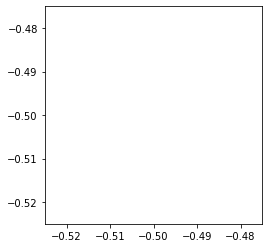

In [95]:
plot.show(mandya_water_mask[4000:6000,8000:10000])